In [1]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import os
import cv2
from keras.models import Sequential,load_model,Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
import tempfile
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path = "/kaggle/input/utk-gender-dataset/UTKFace"
files = os.listdir(path)
size = len(files)
print("Total samples:", size)

np.random.seed(10)
np.random.shuffle(files)

train_files = files[:int(0.8 * size)]
test_files = files[int(0.8 * size):]

temp_dir = tempfile.mkdtemp()

for label in ['0', '1']: 
    os.makedirs(os.path.join(temp_dir, label), exist_ok=True)

for file in train_files:
    src_path = os.path.join(path, file)
    label = file.split('_')[1]
    dst_path = os.path.join(temp_dir, label, file)
    shutil.copyfile(src_path, dst_path)

data_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,
    dtype='float32'
)

train_generator = data_generator.flow_from_directory(
    directory=temp_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True 
)

print("Number of training samples:", len(train_files))

x_train, y_gender = next(train_generator)
print("Shape of x_train:", x_train.shape)
print("Shape of y_gender:", y_gender.shape)

Total samples: 23708
Found 18966 images belonging to 2 classes.
Number of training samples: 18966
Shape of x_train: (32, 224, 224, 3)
Shape of y_gender: (32,)


In [3]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
  conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
  conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)
  conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)
  pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
  output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
  return output

In [4]:
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense,BatchNormalization, Dropout, Input, concatenate
MaxPool2D = MaxPooling2D
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = BatchNormalization()(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
x = inception_module(x,filters_1x1=64,filters_3x3_reduce=96,filters_3x3=128,filters_5x5_reduce=16,filters_5x5=32,filters_pool_proj=32,name='inception_3a')
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=192,filters_5x5_reduce=32,filters_5x5=96,filters_pool_proj=64,name='inception_3b')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
x = inception_module(x,filters_1x1=192,filters_3x3_reduce=96,filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool_proj=64,name='inception_4a')
x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(1, activation='softmax', name='auxilliary_output_1')(x1)
x = inception_module(x,filters_1x1=160,filters_3x3_reduce=112,filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64,name='inception_4b')
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64,name='inception_4c')
x = inception_module(x,filters_1x1=112,filters_3x3_reduce=144,filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64,filters_pool_proj=64,name='inception_4d')
x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same',activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(1, activation='softmax',name='auxilliary_output_2')(x2)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160,filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128,filters_pool_proj=128,name='inception_4e')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2),name='max_pool_4_3x3/2')(x)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160,filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128,filters_pool_proj=128,name='inception_5a')
x = inception_module(x,filters_1x1=384,filters_3x3_reduce=192,filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128,filters_pool_proj=128,name='inception_5b')
x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid', name='output')(x)
model = Model(input_layer, [x, x1, x2], name='inception_v1')
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     

In [5]:
from tensorflow.keras import optimizers
SGD=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=SGD,
              metrics=['accuracy'])

In [6]:
model.fit(train_generator, epochs=20, batch_size=16)

Epoch 1/20
593/593 [==============================] - 75s 87ms/step - loss: 1.6133 - output_loss: 0.5894 - auxilliary_output_1_loss: 0.5083 - auxilliary_output_2_loss: 0.5156 - output_accuracy: 0.6715 - auxilliary_output_1_accuracy: 0.4762 - auxilliary_output_2_accuracy: 0.4762
Epoch 2/20
593/593 [==============================] - 50s 85ms/step - loss: 1.1792 - output_loss: 0.4086 - auxilliary_output_1_loss: 0.3866 - auxilliary_output_2_loss: 0.3840 - output_accuracy: 0.8174 - auxilliary_output_1_accuracy: 0.4762 - auxilliary_output_2_accuracy: 0.4762
Epoch 3/20
593/593 [==============================] - 50s 85ms/step - loss: 0.9958 - output_loss: 0.3398 - auxilliary_output_1_loss: 0.3306 - auxilliary_output_2_loss: 0.3254 - output_accuracy: 0.8531 - auxilliary_output_1_accuracy: 0.4762 - auxilliary_output_2_accuracy: 0.4762
Epoch 4/20
593/593 [==============================] - 50s 84ms/step - loss: 0.8907 - output_loss: 0.2993 - auxilliary_output_1_loss: 0.3007 - auxilliary_output_2_l

In [7]:
temp_dir2 = tempfile.mkdtemp()

# Create subdirectories based on class labels in the temporary directory
for label in ['0', '1']:  # Assuming 'gender' has labels 0 and 1
    os.makedirs(os.path.join(temp_dir2, label), exist_ok=True)

# Copy the test files to the appropriate subdirectories based on class labels
for file in test_files:
    src_path1 = os.path.join(path, file)
    label = file.split('_')[1]
    os.makedirs(os.path.join(temp_dir2, label), exist_ok=True)  # Create subdirectory if not exist
    dst_path1 = os.path.join(temp_dir2, label, file)
    shutil.copyfile(src_path1, dst_path1)

# Create the data generator for loading and preprocessing test images
data_generator_test = ImageDataGenerator(
    rescale=1.0 / 255.0,
    dtype='float32'
)

# Create the test generator
test_generator = data_generator_test.flow_from_directory(
    directory=temp_dir2,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Set class_mode to 'binary'
    classes=['0', '1'],   # Provide the class labels explicitly
    shuffle=False          # Set to False to keep the order of test samples
)

# Display the number of test samples
print("Number of test samples:", len(test_generator.filenames))

# Display the shape of the input data and labels for the test set
x_test, y_gender_test = next(test_generator)
print("Shape of x_test:", x_test.shape)
print("Shape of y_gender_test:", y_gender_test.shape)

Found 4742 images belonging to 2 classes.
Number of test samples: 4742
Shape of x_test: (32, 224, 224, 3)
Shape of y_gender_test: (32,)


In [8]:
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
img_path = "/kaggle/input/utk-gender-dataset/UTKFace/"+test_files[12]
img_file = test_files[12]
img = load_img(img_path, grayscale=False)
img = img.resize((224,224), Image.LANCZOS)
img = np.array(img)

img = img.reshape(1, 224,224,3)
img.shape

img = img/255
input_size = (224,224,3)

Original: Gender =  Female
1/1 [==============================] - 1s 1s/step
Prediction: Gender =  Female


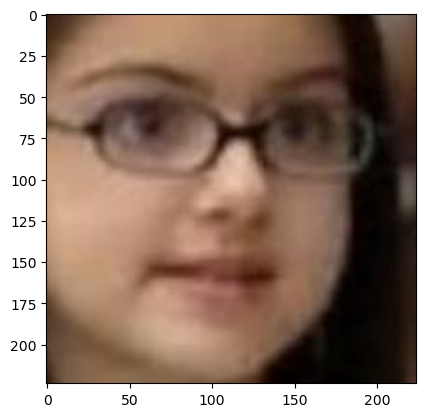

In [9]:
gender_dict = {0:"Male",1:"Female"}
ind = int(img_file.split('_')[1])

print("Original: Gender = ", gender_dict[ind])

pred = model.predict(img.reshape(1, 224, 224, 3))
if(pred[0] > 0.5):
    pred_gender = gender_dict[1]

else:
    pred_gender = gender_dict[0]


print("Prediction: Gender = ", pred_gender)
plt.imshow(img.reshape(224,224,3))

In [11]:
img_path = "/kaggle/input/utk-gender-dataset/UTKFace/"+test_files[1200]
img_file = test_files[1200]
img = load_img(img_path, grayscale=False)
img = img.resize((224,224), Image.LANCZOS)
img = np.array(img)

img = img.reshape(1, 224,224,3)
img.shape

img = img/255
input_size = (224,224,3)

Original: Gender =  Female
1/1 [==============================] - 0s 24ms/step
Prediction: Gender =  Female


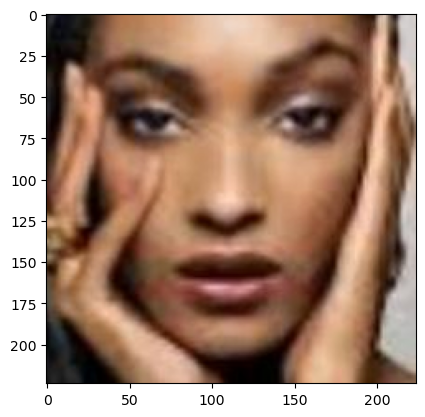

In [12]:
gender_dict = {0:"Male",1:"Female"}
ind = int(img_file.split('_')[1])

print("Original: Gender = ", gender_dict[ind])

pred = model.predict(img.reshape(1, 224, 224, 3))
if(pred[0] > 0.5):
    pred_gender = gender_dict[1]

else:
    pred_gender = gender_dict[0]


print("Prediction: Gender = ", pred_gender)
plt.imshow(img.reshape(224,224,3))

In [16]:
img_path = "/kaggle/input/utk-gender-dataset/UTKFace/"+test_files[3090]
img_file = test_files[3090]
img = load_img(img_path, grayscale=False)
img = img.resize((224,224), Image.LANCZOS)
img = np.array(img)

img = img.reshape(1, 224,224,3)
img.shape

img = img/255
input_size = (224,224,3)

Original: Gender =  Male
1/1 [==============================] - 0s 23ms/step
Prediction: Gender =  Male


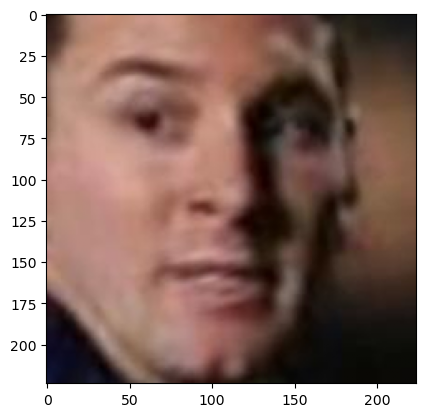

In [17]:
gender_dict = {0:"Male",1:"Female"}
ind = int(img_file.split('_')[1])

print("Original: Gender = ", gender_dict[ind])

pred = model.predict(img.reshape(1, 224, 224, 3))
if(pred[0] > 0.5):
    pred_gender = gender_dict[1]

else:
    pred_gender = gender_dict[0]


print("Prediction: Gender = ", pred_gender)
plt.imshow(img.reshape(224,224,3))

In [18]:
pred = model.evaluate(test_generator)
print("Testing accuracy is: ",pred[4])

149/149 [==============================] - 10s 61ms/step - loss: 0.9128 - output_loss: 0.3007 - auxilliary_output_1_loss: 0.3106 - auxilliary_output_2_loss: 0.3015 - output_accuracy: 0.9026 - auxilliary_output_1_accuracy: 0.4819 - auxilliary_output_2_accuracy: 0.4819
Testing accuracy is:  0.902572751045227


In [19]:
# Create an empty list to store all the labels for all batches
all_y_gender_test = []

# Loop through the test_generator to get all the batches
for i in range(len(test_generator)):
    # Get the next batch of data and labels
    x_batch, y_gender_batch = next(test_generator)
    
    # Append the batch labels to the list
    all_y_gender_test.extend(y_gender_batch)

# Convert the list to a NumPy array for further processing (optional)
all_y_gender_test = np.array(all_y_gender_test)

# Display the shape of the concatenated y_gender_test
print("Shape of all_y_gender_test:", all_y_gender_test.shape)

Shape of all_y_gender_test: (4742,)


In [20]:
pred= model.predict(test_generator)
predicted_labels = []
batch_labels = (pred[0] > 0.5).astype(int)
predicted_labels.extend(batch_labels)
predicted_labels = np.array(predicted_labels)

149/149 [==============================] - 9s 55ms/step


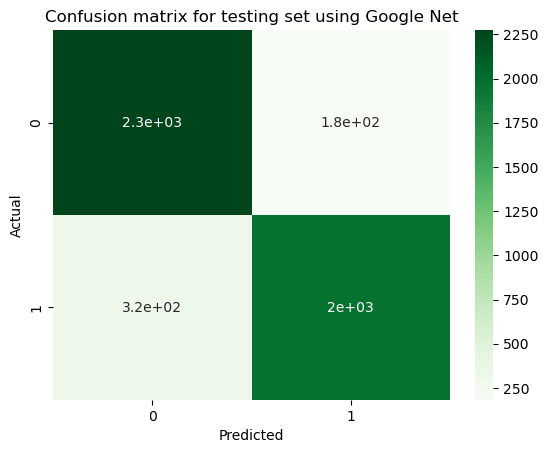

In [21]:
# Compute confusion
sns.heatmap(confusion_matrix(all_y_gender_test, predicted_labels), annot=True, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for testing set using Google Net')
plt.show()

In [22]:
#precision
gn_precision = precision_score(all_y_gender_test, predicted_labels)
print("Precision:",gn_precision)
print("\n")
#recall
gn_recall = recall_score(all_y_gender_test, predicted_labels)
print("Recall:",gn_recall)
print("\n")
#f1score
gn_f1score = f1_score(all_y_gender_test, predicted_labels)
print("F1 score:",gn_f1score)
print("\n")
# Computing the true positive rate and false positive rate 
gn_cm = confusion_matrix(all_y_gender_test, predicted_labels)
gn_tpr = gn_cm[1, 1] / (gn_cm[1, 1] + gn_cm[1, 0])
gn_fpr = gn_cm[0, 1] / (gn_cm[0, 1] + gn_cm[0, 0])
print("True positive rate:", gn_tpr)
print("\n")
print("False positive rate:", gn_fpr)

Precision: 0.9149232914923291


Recall: 0.8612691466083151


F1 score: 0.8872858431018936


True positive rate: 0.8612691466083151


False positive rate: 0.07448107448107448
